<a href="https://colab.research.google.com/github/durg3sh10/Named_Entity_Recognition/blob/main/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Named Entity Recognition (NER)** - <font color='blue'>  Univ.AI</font>

# **Motivation** 

Named entity recognition (NER)is probably the first step towards information extraction 
that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons, 
organizations, locations, expressions of times, quantities, monetary values, percentages, etc. NER is used in many 
fields in Natural Language Processing (NLP), and it can help answering many real-world questions, such as:

Which companies were mentioned in the news article?
Were specified products mentioned in complaints or reviews?
Does the tweet contain the name of a person? Does the tweet contain this person’s location?



# ***How is NER used?***


NER is suitable for any situation where a high-level overview of large amounts of text is useful. With NER, you can understand the subject or topic of a text at a glance and quickly group texts based on their relevance or similarity.

Some notable use cases of NER include:

1. Human Resources: *italicised text*
Speed ​​up the hiring process by summarizing applicant resumes; improve internal work processes by categorizing employee complaints and queries

2. Customer support: *italicised text*
Improve response time by categorizing user requests, complaints and questions and filtering by priority keywords

3. Search and recommendation tools: *italicised text*
Improve the speed and relevance of search results and recommendations by summarizing descriptive text, reviews and discussions
Booking.com is a notable success story here

4. Content classification: *italicised text*
Easier to display content and gain insight into trends by identifying the topics and themes of blog posts and news articles
Health care

5. Improve standards of patient care and reduce workload by extracting essential information from laboratory reports
Roche does this using pathology and radiology reports

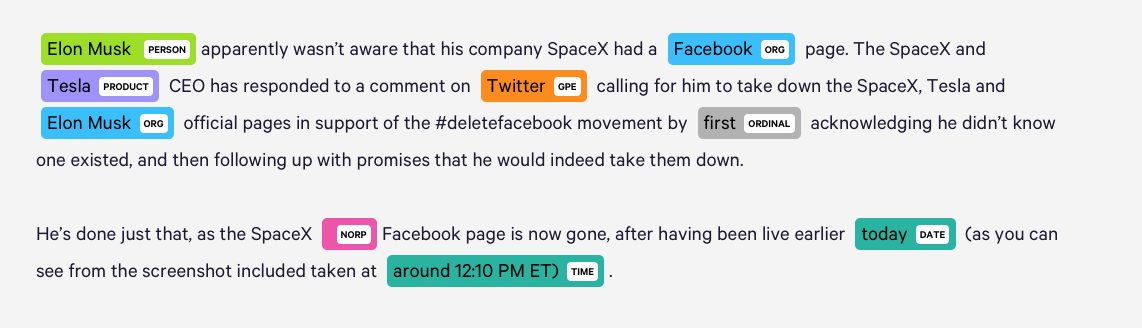

### Dataset Description
Datasets from the NASA Astrophysical Data System that contain text snippets from astrophysics articles that have been carefully labelled with astronomical facilities and other entities of interest (e.g., celestial objects).
The JSON Lines format is used for data sets (each line is a json dictionary).
The datasets follow the CONLL2003 formatting guidelines. Each token has a NER tag attached to it. The tags follow to the IOB2 syntax's "B-" and "I-" conventions.

Link: https://huggingface.co/datasets/fgrezes/WIESP2022-NER

In [181]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional,LSTM,Dense, TimeDistributed, SimpleRNN

Each entry consists of a dictionary with the following keys:

* "unique_id": a unique identifier for this data sample. Must be included in the predictions.
* "tokens": the list of tokens (strings) that form the text of this sample. Must be included in the predictions.
* "ner_tags": the list of NER tags (in IOB2 format)
The following keys are not strictly needed by the participants:

* "ner_ids": the pre-computed list of ids corresponding ner_tags, as given by the dictionary in ner_tags.json
* "label_studio_id", "section", "bibcode": references for internal NASA/ADS use.

In [182]:
import json
with open("/content/drive/MyDrive/Dataset/language_modeling/NER/WIESP2022-NER-TRAINING.jsonl", 'r') as f:
    wiesp_dev_json = [json.loads(l) for l in list(f)]

In [183]:
# Calling DataFrame constructor on list
df_train = pd.DataFrame(wiesp_dev_json)
print('Training Data shape: ', df_train.shape)
df_train.head()

Training Data shape:  (1753, 7)


,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,2018MNRAS.478.5533F,1129,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F
2,2018MNRAS.480.3062L,1086,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
3,2016MNRAS.457.1786M,1135,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...",acknowledgments,"[BDM, gratefully, acknowledges, support, from,...",acknowledgments_1135_2016MNRAS.457.1786M
4,2019MNRAS.482L...9B,559,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B


In [184]:
list(df_train.columns)

['bibcode',
 'label_studio_id',
 'ner_ids',
 'ner_tags',
 'section',
 'tokens',
 'unique_id']

In [185]:
df_train =  df_train[['ner_ids', 'ner_tags', 'tokens']]

#Remove characters
df_train["tokens"] = df_train["tokens"].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s\']', '', i) for i in x])
df_train.head()

,ner_ids,ner_tags,tokens
0,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...","[Whilst, a, reasonable, harmonic, fit, to, the..."
1,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[comparison, once, the, angular, positions, of..."
2,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ACKNOWLEDGEMENTS, The, authors, thank, an, an..."
3,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...","[BDM, gratefully, acknowledges, support, from,..."
4,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...","[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey, ..."


In [186]:
df_train.shape

(1753, 3)

In [187]:
# Mapping tags to ids
df_ner_tags = df_train.explode("ner_tags", ignore_index=False)
Ner_tags = df_ner_tags["ner_tags"].unique()
print(Ner_tags.shape)

df_ner_ids = df_train.explode("ner_ids", ignore_index=False)
Ner_ids = df_ner_ids["ner_ids"].unique()
print(Ner_ids.shape)

tag_to_id = dict(zip(Ner_tags, Ner_ids))
id_to_tag = {j:i for i,j in tag_to_id.items()}

(63,)
(63,)


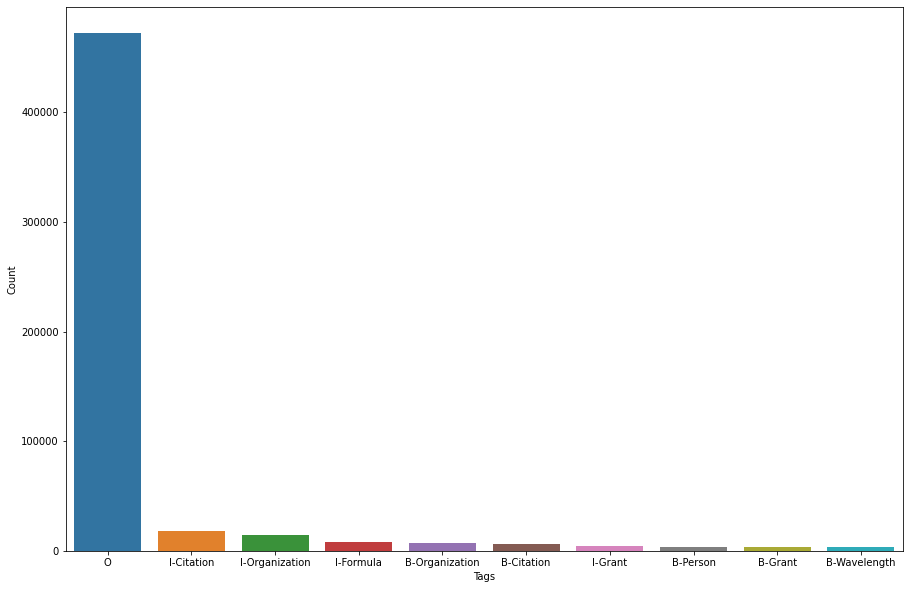

In [188]:
# Top 10 ner tags plots in train dataset
tag_count = df_ner_tags["ner_tags"].value_counts()
tags = tag_count.index
values = tag_count.tolist()
plt.figure(figsize=(15,10))
sns.barplot(x=tags[:10], y=values[:10])
plt.xlabel('Tags')
plt.ylabel('Count');

In [189]:
# Mapping token to ids
df_tokens = df_train.explode("tokens", ignore_index=False)
tokens = list(df_tokens["tokens"].unique())
tokens.sort()

token_to_id = {j:i+1 for i,j in enumerate(tokens)}
id_to_token = {i+1:j for i,j in enumerate(tokens)}
# token_to_id["<PAD>"] = 0
# id_to_token[0] = "<PAD>"

In [ ]:
# print(id_to_token)
# print(token_to_id)

In [191]:
df_train["token_id"] =  df_train["tokens"].apply(lambda x: [token_to_id[i] for i in x])
df_train.head(2)

,ner_ids,ner_tags,tokens,token_id
0,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...","[Whilst, a, reasonable, harmonic, fit, to, the...","[19480, 19940, 29018, 24686, 24043, 31335, 311..."
1,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[comparison, once, the, angular, positions, of...","[21713, 27513, 31177, 20359, 28305, 27472, 311..."


In [192]:
# Max len of a sentence tokens
sentences = df_train["token_id"].tolist()
print("Num of Sentences", len(sentences))
max_len_sen = max([len(i) for i in sentences])
print("Length of max sentence", max_len_sen)

# Max len of ner tags
ner_tags = df_train["ner_ids"].tolist()
max_len_tag = max([len(i) for i in ner_tags])

Num of Sentences 1753
Length of max sentence 795


In [193]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(sentences, padding="post", maxlen= max_len_sen, value=token_to_id["the"])
y = pad_sequences(ner_tags, padding="post", maxlen= max_len_tag, value=62)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1)
print("shape of X_train is:",X_train.shape)
print("shape of X_test is:",X_test.shape)
print("shape of y_train is:",y_train.shape)
print("shape of y_test is:",y_test.shape)

shape of X_train is: (1577, 795)
shape of X_test is: (176, 795)
shape of y_train is: (1577, 795)
shape of y_test is: (176, 795)


In [194]:
vocab_size = (len(token_to_id.keys())+1)
print("Vocab size: ",len(token_to_id.keys())+1)

Vocab size:  32469


In [195]:
def get_model(model_name, num_of_units, vocab_size):

  # Clear the tensorflow session
  tf.keras.backend.clear_session()

  # Defining the input layer
  input_layer = Input(shape=(795,))

  # Adding a embedding layer
  word_emb = Embedding(vocab_size, 30)(input_layer)

  # Adding the 1st layer
  layer1 = model_name(num_of_units, return_sequences=True)(word_emb)

  # Adding the 2nd layer
  layer2 = model_name(num_of_units, return_sequences=True)(layer1)

  # Defining the output layer with 63 nodes and softmax activation
  output_layer1 = Dense(63, activation='softmax')(layer2)

  # Combining the input and output to form the language model
  model = Model(inputs = input_layer, outputs = output_layer1)

  # Model Summary
  model_summary = tf.keras.utils.plot_model(model, show_shapes=True)

  #Compile the model
  model.compile(optimizer= 'adam', loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

  # Using callback in keras
  callback = tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True)

  # Fit the model
  history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[callback])

  return model, history, model_summary

In [196]:
def get_accuracy_plots(model_history):
  # Ploting the train and validation accuracy of the model
  plt.rcParams["figure.figsize"] = (10,8)
  plt.title("NER Model")
  plt.plot(model_history.history['accuracy'], label='Train accuracy', color='#FF9A98')
  plt.plot(model_history.history['val_accuracy'],  label='Validation accuracy', color='#75B594')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy');

In [197]:
def get_loss_plots(model_history):
  # Ploting the train and validation loss of the model
  plt.rcParams["figure.figsize"] = (10,8)
  plt.title("NER Model Loss")
  plt.plot(model_history.history['loss'], label='Train loss', color='#FF9A98')
  plt.plot(model_history.history['val_loss'],  label='Validation loss', color='#75B594')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss');

In [198]:
# from tensorflow import keras
# model1 = keras.models.load_model("/content/drive/MyDrive/Dataset/language_modeling/NER/model/simplernn.h5")

In [199]:
rnn_model, rnn_hist, rnn_summary = get_model(SimpleRNN, 64, vocab_size)
rnn_model.save("/content/drive/MyDrive/Dataset/language_modeling/NER/model/simplernn.h5")

Epoch 1/20
40/40 [==============================] - 60s 1s/step - loss: 1.2110 - accuracy: 0.8562 - val_loss: 0.5241 - val_accuracy: 0.9272
Epoch 2/20
40/40 [==============================] - 57s 1s/step - loss: 0.5084 - accuracy: 0.9270 - val_loss: 0.5012 - val_accuracy: 0.9272
Epoch 3/20
40/40 [==============================] - 54s 1s/step - loss: 0.4971 - accuracy: 0.9270 - val_loss: 0.4969 - val_accuracy: 0.9272
Epoch 4/20
40/40 [==============================] - 56s 1s/step - loss: 0.5096 - accuracy: 0.9256 - val_loss: 0.4932 - val_accuracy: 0.9272
Epoch 5/20
40/40 [==============================] - 53s 1s/step - loss: 0.5160 - accuracy: 0.9247 - val_loss: 0.4887 - val_accuracy: 0.9272
Epoch 6/20
40/40 [==============================] - 55s 1s/step - loss: 0.5282 - accuracy: 0.9223 - val_loss: 0.4682 - val_accuracy: 0.9258
Epoch 7/20
40/40 [==============================] - 56s 1s/step - loss: 0.4711 - accuracy: 0.9262 - val_loss: 0.4187 - val_accuracy: 0.9272
Epoch 8/20
40/40 [==

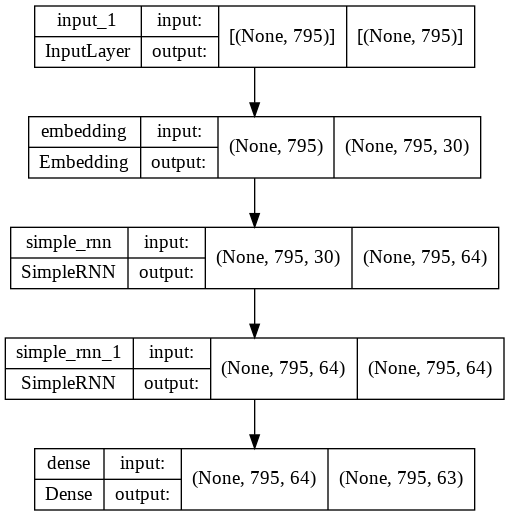

In [200]:
rnn_summary

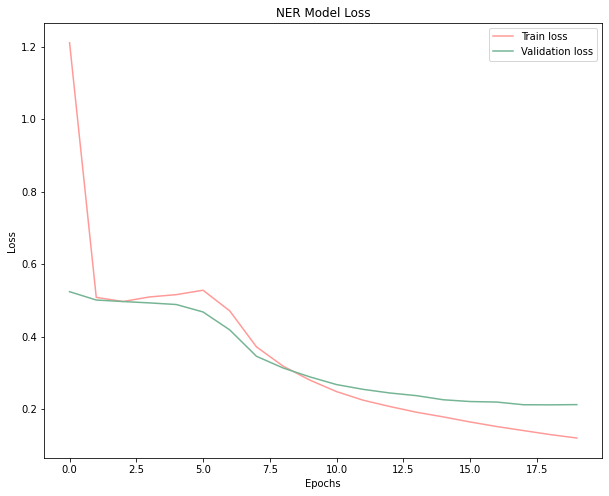

In [201]:
get_loss_plots(rnn_hist)

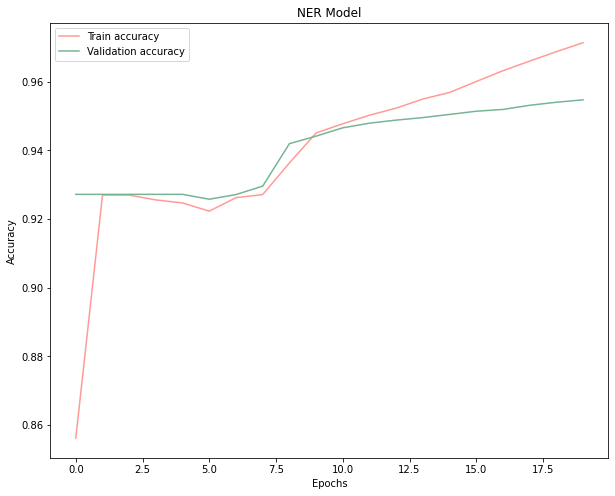

In [202]:
get_accuracy_plots(rnn_hist)

In [203]:
score = rnn_model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 113ms/step - loss: 0.1863 - accuracy: 0.9602


In [209]:
y_pred = rnn_model.predict(X_test)
y_pred = np.argmax(np.array(y_pred), axis=-1)

In [210]:
print("Y true: ", [id_to_tag[i] for i in y_pred[0]])
print("Y pred: ", [id_to_tag[i] for i in y_test[0]])

Y true:  ['O', 'O', 'O', 'B-Organization', 'I-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organization', 'O', 'B-Person', 'O', 'O', 'O', 'O', 'B-Organization', 'I-Organization', 'I-Organization', 'I-Organization', 'O', 'B-Grant', 'I-Grant', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [205]:
lstm_model, lstm_hist, lstm_summary = get_model(LSTM, 64, vocab_size)
lstm_model.save("/content/drive/MyDrive/Dataset/language_modeling/NER/model/lstm.h5")

Epoch 1/20
40/40 [==============================] - 60s 75ms/step - loss: 1.6395 - accuracy: 0.9037 - val_loss: 0.5591 - val_accuracy: 0.9272
Epoch 2/20
40/40 [==============================] - 2s 54ms/step - loss: 0.5225 - accuracy: 0.9270 - val_loss: 0.5090 - val_accuracy: 0.9272
Epoch 3/20
40/40 [==============================] - 2s 55ms/step - loss: 0.5052 - accuracy: 0.9270 - val_loss: 0.5046 - val_accuracy: 0.9272
Epoch 4/20
40/40 [==============================] - 2s 54ms/step - loss: 0.5018 - accuracy: 0.9270 - val_loss: 0.5026 - val_accuracy: 0.9272
Epoch 5/20
40/40 [==============================] - 2s 54ms/step - loss: 0.4995 - accuracy: 0.9270 - val_loss: 0.5003 - val_accuracy: 0.9272
Epoch 6/20
40/40 [==============================] - 2s 55ms/step - loss: 0.4972 - accuracy: 0.9270 - val_loss: 0.4985 - val_accuracy: 0.9272
Epoch 7/20
40/40 [==============================] - 2s 55ms/step - loss: 0.4937 - accuracy: 0.9269 - val_loss: 0.4942 - val_accuracy: 0.9272
Epoch 8/20
4

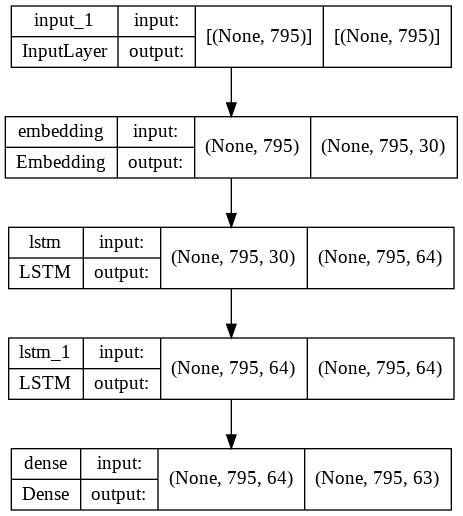

In [206]:
lstm_summary

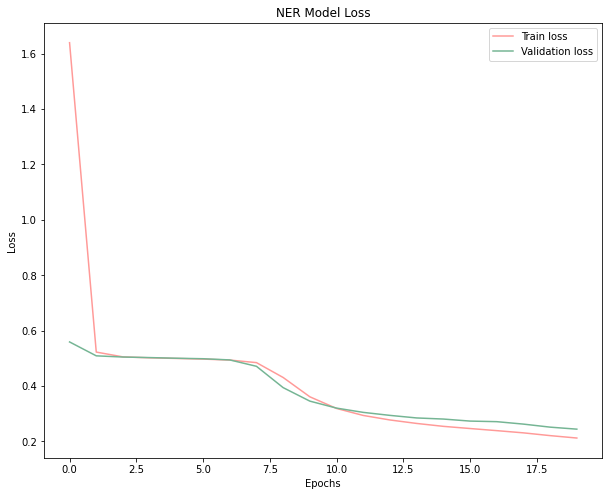

In [207]:
get_loss_plots(lstm_hist)

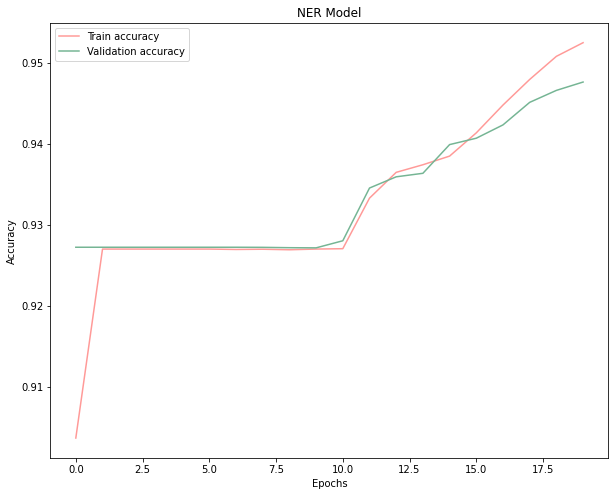

In [208]:
get_accuracy_plots(lstm_hist)

In [211]:
score = lstm_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 42ms/step - loss: 0.2207 - accuracy: 0.9516


In [212]:
y_pred = lstm_model.predict(X_test)
y_pred = np.argmax(np.array(y_pred), axis=-1)

In [213]:
print("Y true: ", [id_to_tag[i] for i in y_pred[0]])
print("Y pred: ", [id_to_tag[i] for i in y_test[0]])

Y true:  ['O', 'O', 'O', 'O', 'I-Citation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organization', 'I-Organization', 'I-Organization', 'I-Organization', 'I-Organization', 'I-Organization', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'